In [5]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#function to convert all images from bgr to rgb and resizing
#getting all image data in the form of a list called 'data' split into different class folders

labels = ['Bicycle','Bridge','Bus','Car','Traffic Light']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        i=0
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)
        #print(class_num)
        for img in os.listdir(path):
            try:
                i+=1
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshape images to preferred size
                if [resized_arr, class_num]!=None:
                  data.append([resized_arr, class_num])
                #print(i, end=' ')
            except Exception as e:
                print(e)
        #print()
    return data # Don't convert to a NumPy array here

In [4]:
#loading test and train images
train = get_data('/content/drive/MyDrive/Google_Recaptcha_V2_Images_Dataset/train')
test = get_data('/content/drive/MyDrive/Google_Recaptcha_V2_Images_Dataset/test')

Text(0.5, 1.0, 'Bicycle')

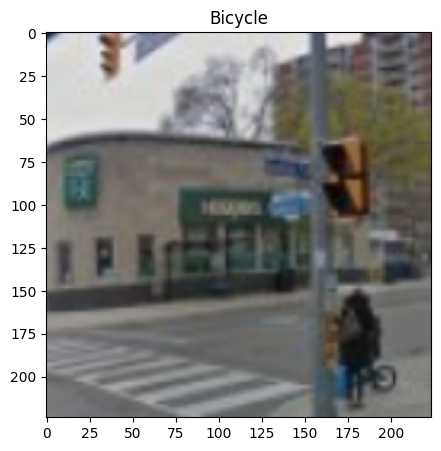

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Traffic Light')

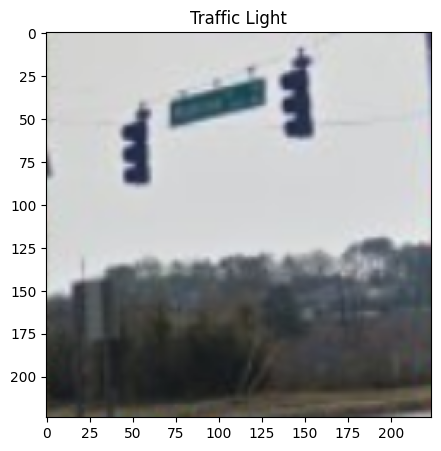

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [5]:
#duplicating data into lists with elements [feature,label]
#train-training val-testing

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [6]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [7]:
datagen.fit(x_train)

In [8]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

# Add a global average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with one neuron for binary classification
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

# Combine the base model and the custom classification layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=5)
y_val_encoded = to_categorical(y_val, num_classes=5)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Appropriate for one-hot encoded labels
              metrics=['accuracy'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.4 MB/s eta 0:00:00


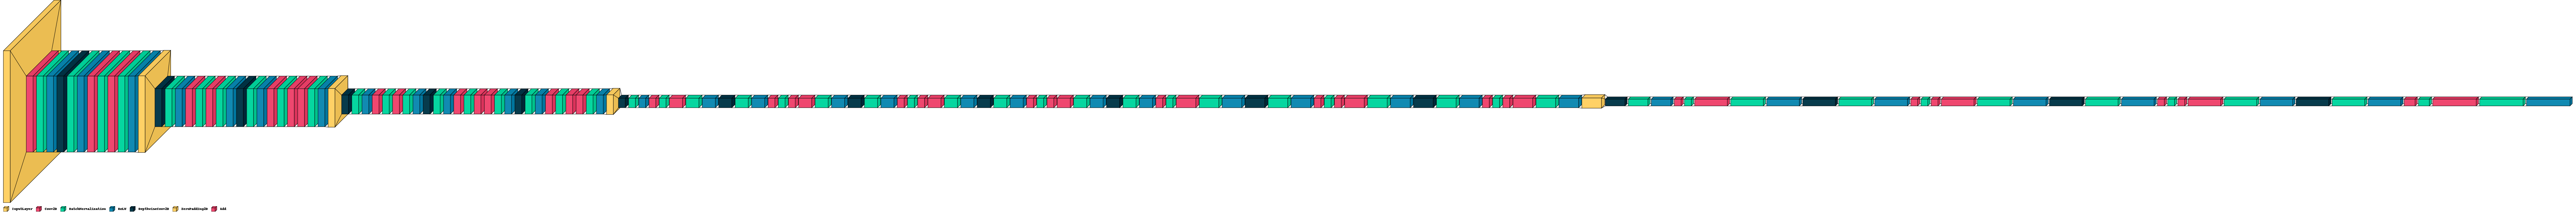

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(base_model).show() # display model architecture
visualkeras.layered_view(base_model, legend=True,scale_xy=2)

In [10]:
# Train the model
history = model.fit(x_train, y_train_encoded, epochs=30, steps_per_epoch=8,
                    validation_data=(x_val, y_val_encoded), verbose=1)


# Save the trained model
model.save('recaptcha.h5')

Epoch 1/30
8/8 [==============================] - 157s 20s/step - loss: 1.7136 - accuracy: 0.3099 - val_loss: 1.7391 - val_accuracy: 0.3220
Epoch 2/30
8/8 [==============================] - 158s 20s/step - loss: 1.2204 - accuracy: 0.5385 - val_loss: 1.1740 - val_accuracy: 0.5220
Epoch 3/30
8/8 [==============================] - 151s 20s/step - loss: 0.9262 - accuracy: 0.6788 - val_loss: 0.9624 - val_accuracy: 0.6400
Epoch 4/30
8/8 [==============================] - 134s 17s/step - loss: 0.7484 - accuracy: 0.7389 - val_loss: 0.7901 - val_accuracy: 0.7280
Epoch 5/30
8/8 [==============================] - 133s 17s/step - loss: 0.6455 - accuracy: 0.7811 - val_loss: 0.6977 - val_accuracy: 0.7840
Epoch 6/30
8/8 [==============================] - 140s 18s/step - loss: 0.5834 - accuracy: 0.8034 - val_loss: 0.6336 - val_accuracy: 0.7960
Epoch 7/30
8/8 [==============================] - 153s 20s/step - loss: 0.5363 - accuracy: 0.8158 - val_loss: 0.5905 - val_accuracy: 0.8080
Epoch 8/30
8/8 [====

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [14]:
epochs_range = range(30)

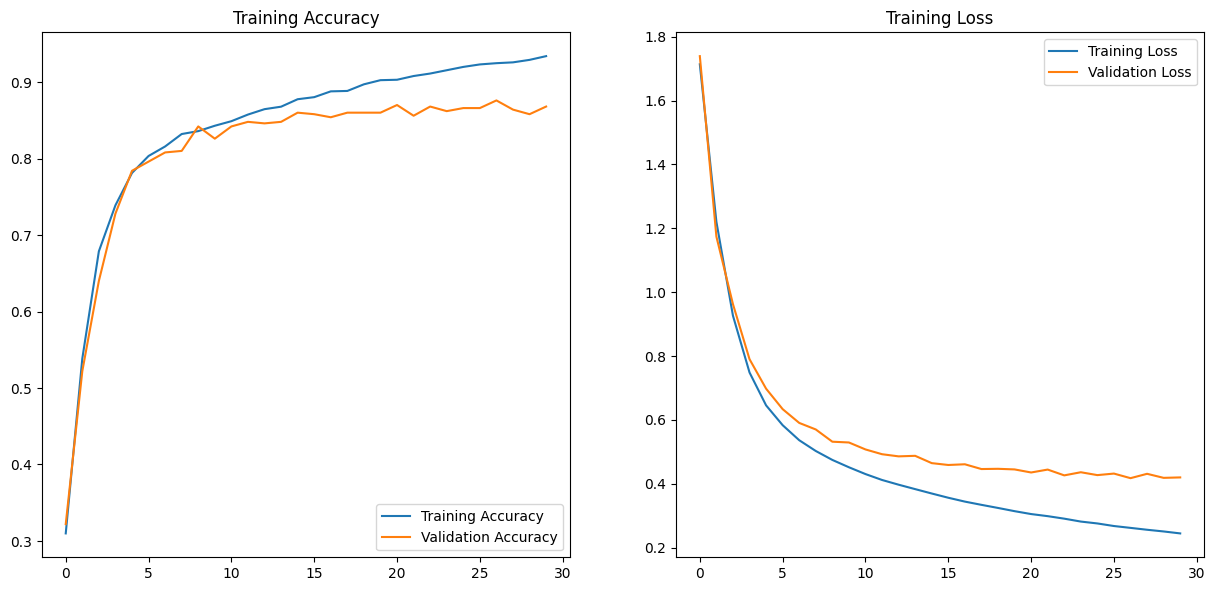

In [15]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [16]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Load the .h5 model
model_path = '/content/drive/MyDrive/recaptcha.h5'
model = tf.keras.models.load_model(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Get class probabilities
class_probabilities = model.predict(x_val)

# Determine predicted classes
#predicted=[]
#for img in class_probabilities:
 # max_value = max(img)
  #max_index = list(class_probabilities[img]).index(max_value)
  #predicted.append(max_index)
predicted_classes = np.argmax(class_probabilities, axis=1)

# Print or use predicted classes
print(predicted_classes)

16/16 [==============================] - 25s 1s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 4 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 4 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 1 1 3 1 1 1 3 1 1 1 1 2 1 1
 1 1 4 1 1 1 1 1 2 1 3 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 2 4 1 1 3 1 1 1 1 1
 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 2 0 2 2 2 4 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 0 2 2 2 2 2 2 2 4 2 2 4 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 4 3 3 3 1
 3 3 3 1 3 3 3 3 3 4 3 3 3 2 3 2 3 2 3 4 3 2 3 3 3 4 3 3 3 3 3 1 0 3 3 3 3
 2 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 2 3 2 3 3 3 3 3 4 4 3 4 4 4 4
 4 4 4 3 4 4 4 3 4 4 4 4 2 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 2 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 3 0 4 4 4 

In [19]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming 'y_val' contains the true class labels (ground truth) and 'predictions' contains the predicted class labels
# Define the target class names for the report (4 classes in this case)
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Generate the classification report
report = classification_report(y_val, predicted_classes, target_names=target_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Class 0       0.94      0.95      0.95       100
     Class 1       0.94      0.82      0.88       100
     Class 2       0.81      0.91      0.86       100
     Class 3       0.81      0.81      0.81       100
     Class 4       0.85      0.85      0.85       100

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



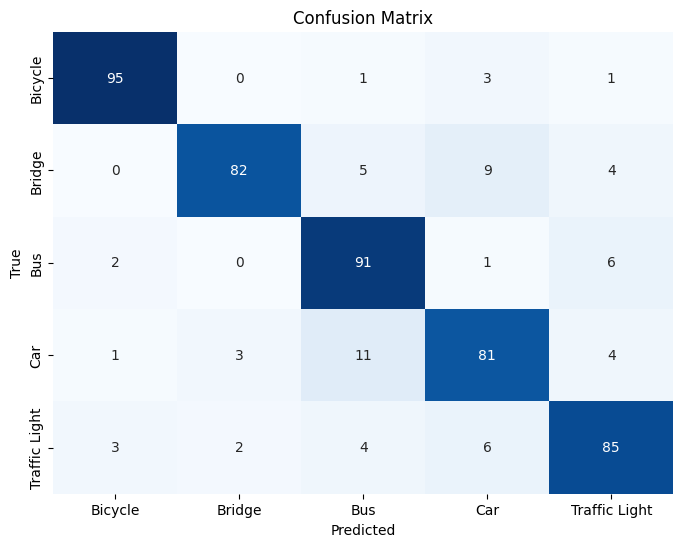

Label: Bicycle
True Positives (TP): 95
True Negatives (TN): 394
False Positives (FP): 5
False Negatives (FN): 6

Label: Bridge
True Positives (TP): 82
True Negatives (TN): 395
False Positives (FP): 18
False Negatives (FN): 5

Label: Bus
True Positives (TP): 91
True Negatives (TN): 379
False Positives (FP): 9
False Negatives (FN): 21

Label: Car
True Positives (TP): 81
True Negatives (TN): 381
False Positives (FP): 19
False Negatives (FN): 19

Label: Traffic Light
True Positives (TP): 85
True Negatives (TN): 385
False Positives (FP): 15
False Negatives (FN): 15



In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate the confusion matrix
confusion = confusion_matrix(np.argmax(y_val_encoded, axis=1), predicted_classes)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Extract TP, TN, FP, and FN values from the confusion matrix
tp = confusion.diagonal()
tn = np.sum(confusion) - np.sum(confusion, axis=0) - np.sum(confusion, axis=1) + tp
fp = np.sum(confusion, axis=1) - tp
fn = np.sum(confusion, axis=0) - tp
# Print TP, TN, FP, and FN values
for i, label in enumerate(labels):
    print(f"Label: {label}")
    print(f"True Positives (TP): {tp[i]}")
    print(f"True Negatives (TN): {tn[i]}")
    print(f"False Positives (FP): {fp[i]}")
    print(f"False Negatives (FN): {fn[i]}\n")

1/1 [==============================] - 1s 942ms/step


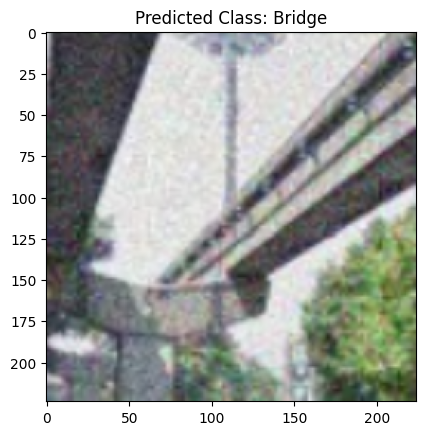

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

labels = ['Bicycle','Bridge','Bus','Car','Traffic Light']

# Load the .h5 model
model_path = '/content/drive/MyDrive/recaptcha.h5'
model = tf.keras.models.load_model(model_path)

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/Google_Recaptcha_V2_Images_Dataset/test/Bridge/Bridge (106).png'
input_image = cv2.imread(input_image_path)[..., ::-1]  # Convert BGR to RGB
input_image = cv2.resize(input_image, (224, 224))  # Resize to 224x224 pixels
input_image = input_image / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the trained model
class_probabilities = model.predict(np.expand_dims(input_image, axis=0))
predicted_class_index = np.argmax(class_probabilities)
predicted_class_label = labels[predicted_class_index]

# Display the input image, predicted class, and class probabilities (if needed)
plt.imshow(input_image)
plt.title(f'Predicted Class: {predicted_class_label}')
plt.show()

1/1 [==============================] - 0s 71ms/step


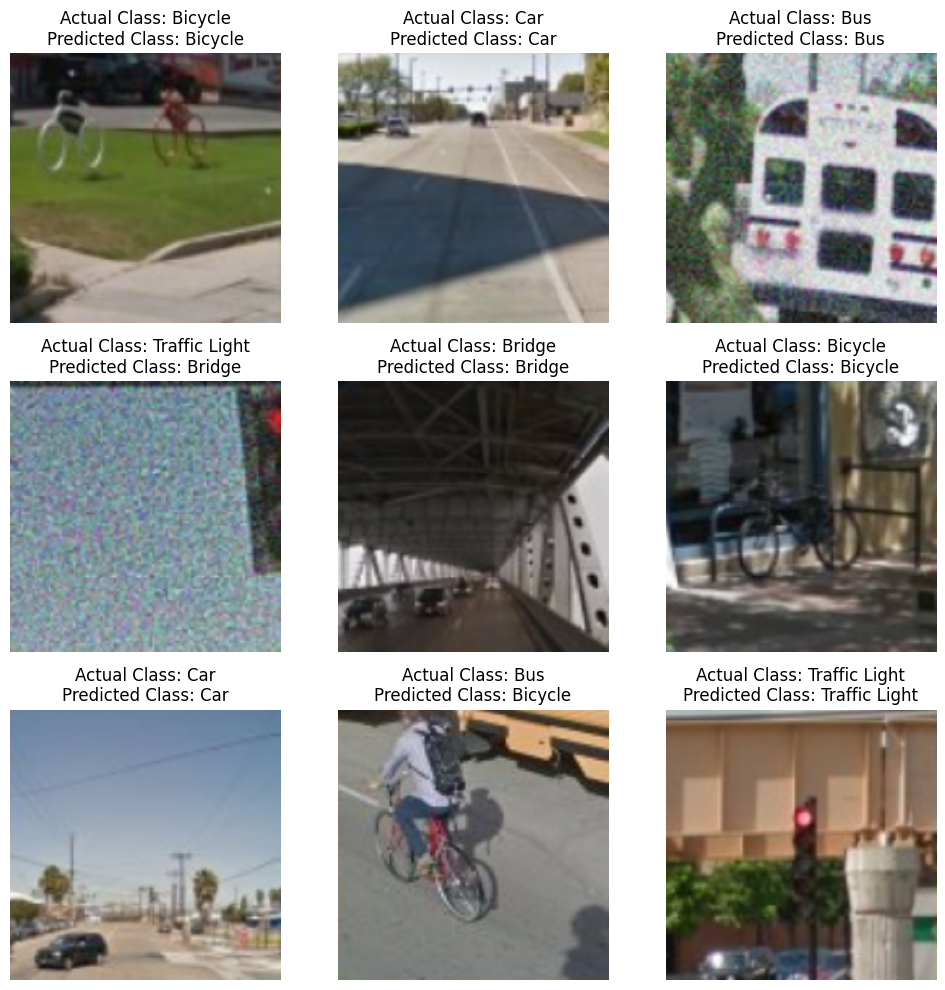

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Traffic Light']

# Load the .h5 model
model_path = '/content/drive/MyDrive/recaptcha.h5'
model = tf.keras.models.load_model(model_path)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    input_image = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    input_image = cv2.resize(input_image, (224, 224))  # Resize to 224x224 pixels
    input_image = input_image / 255.0  # Normalize pixel values to [0, 1]
    return input_image

# Load the input image with 9 images in a 3x3 grid
input_image_path = '/path/to/your/input/image.jpg'
input_image = cv2.imread(input_image_path)[..., ::-1]  # Convert BGR to RGB

# Split the input image into a 3x3 grid
sub_images = [input_image[i:i+224, j:j+224] for i in range(0, 672, 224) for j in range(0, 672, 224)]

# Create a subplot with 4 rows and 3 columns
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

# Display the input image in the first row
axs[0, 0].imshow(input_image)
axs[0, 0].set_title('Input Image')
axs[0, 0].axis('off')

for i in range(3):
    for j in range(3):
        # Preprocess each sub-image
        input_sub_image = sub_images[i * 3 + j] / 255.0  # Normalize pixel values to [0, 1]

        # Make predictions using the trained model
        class_probabilities = model.predict(np.expand_dims(input_sub_image, axis=0))
        predicted_class_index = np.argmax(class_probabilities)
        predicted_class_label = labels[predicted_class_index]

        # Display the input sub-image and predicted class
        axs[i + 1, j].imshow(input_sub_image)
        axs[i + 1, j].set_title(f'Predicted Class: {predicted_class_label}')

        # Remove axes
        axs[i + 1, j].axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 97ms/step


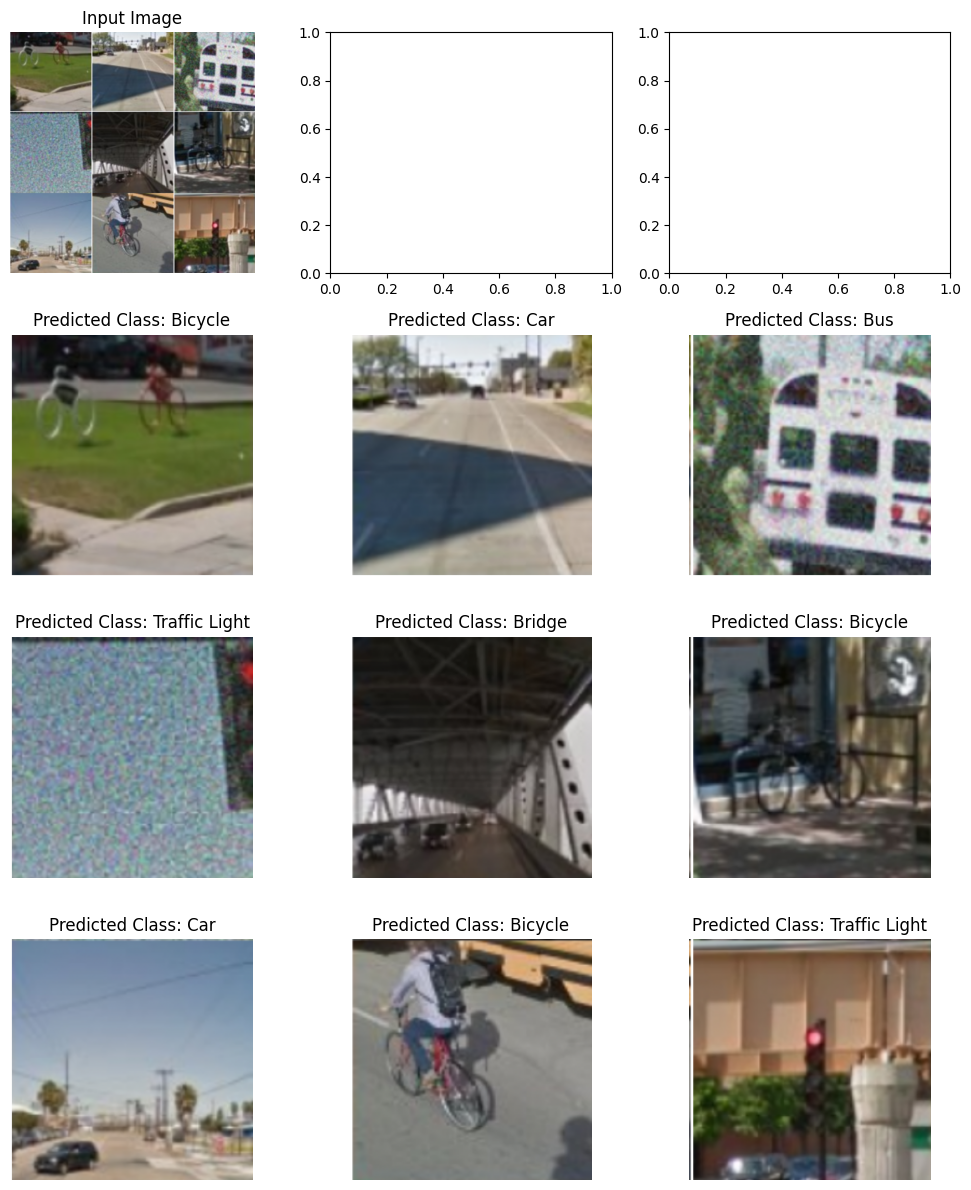

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Traffic Light']

# Load the .h5 model
model_path = '/content/drive/MyDrive/recaptcha.h5'
model = tf.keras.models.load_model(model_path)

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    input_image = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    input_image = cv2.resize(input_image, (224, 224))  # Resize to 224x224 pixels
    input_image = input_image / 255.0  # Normalize pixel values to [0, 1]
    return input_image

# Load the input image with 9 images in a 3x3 grid
input_image_path = '/content/drive/MyDrive/download.png'
input_image = cv2.imread(input_image_path)[..., ::-1]  # Convert BGR to RGB

# Calculate the dimensions for the sub-images
num_rows, num_cols = 3, 3
sub_image_size = 224
input_height, input_width, _ = input_image.shape

# Calculate the step size for splitting the image
step_size_rows = input_height // num_rows
step_size_cols = input_width // num_cols

# Create a subplot with 4 rows and 3 columns
fig, axs = plt.subplots(num_rows + 1, num_cols, figsize=(10, 12))

# Display the input image in the first row
axs[0, 0].imshow(input_image)
axs[0, 0].set_title('Input Image')
axs[0, 0].axis('off')

for i in range(num_rows):
    for j in range(num_cols):
        # Calculate the starting and ending indices for the sub-image
        start_row, end_row = i * step_size_rows, (i + 1) * step_size_rows
        start_col, end_col = j * step_size_cols, (j + 1) * step_size_cols

        # Extract the sub-image
        input_sub_image = input_image[start_row:end_row, start_col:end_col]

        # Preprocess each sub-image
        input_sub_image = cv2.resize(input_sub_image, (sub_image_size, sub_image_size)) / 255.0  # Resize and normalize

        # Make predictions using the trained model
        class_probabilities = model.predict(np.expand_dims(input_sub_image, axis=0))
        predicted_class_index = np.argmax(class_probabilities)
        predicted_class_label = labels[predicted_class_index]

        # Display the input sub-image and predicted class
        axs[i + 1, j].imshow(input_sub_image)
        axs[i + 1, j].set_title(f'Predicted Class: {predicted_class_label}')

        # Remove axes
        axs[i + 1, j].axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()